Using:
    https://gist.github.com/EdwardJRoss/86b31848a7951411de56f10f55e9de4e
    https://forums.fast.ai/t/character-level-language-model/31379

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
import string

In [3]:
# bs=48
# bs=24
bs=192

In [4]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [7]:
df = pd.read_csv('/home/trpb2/data/takeaway/takeaway_names.txt', header = None)

In [9]:
df['name'] = df.name.str.lower()

In [10]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
valid_df = df[~msk]

In [11]:
train_df

,name
1,squires restaurant
2,silver spoon kitchen
3,akwaahs kitchen
4,bronze restaurant
5,la bell cuisine
7,nikki's place
8,orchard
9,dixy chicken
10,divine flavouz african cuisine
12,flavorz


In [12]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [13]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'" +"0123456789")

In [14]:
itos

['xxunk',
 'xxbos',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 ' ',
 '-',
 "'",
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [15]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [19]:
data = TextLMDataBunch.from_df(path='.', train_df=train_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab, text_cols=0, mark_fields=False, bs=128)

In [17]:
data.show_batch()

idx,text
0,s t a u r a n t xxbos l a b e l l c u i s i n e xxbos n i k k i ' s p l a c e xxbos o r c h a r d xxbos d i x y c h i c k e
1,i n o ' s 2 xxbos t h e o v a l l o u n g e xxbos m a r k e t c a f e s u n d a y d i n n e r d e l i v e r xxunk xxunk
2,g d r a g o n a c t o n xxbos w e s t v i e w c h i n e s e xxbos w i n g f u xxbos j a s m i n e g a r d e n xxbos n e
3,r a g o n - i xxbos n e w c h o p c h o p xxbos y u m m y c i t y xxbos t h e g r e a t w a l l xxbos h o w a h xxbos
4,s c o o k i n g xxbos y u m m y k i n g xxbos s i l v e r s e a c h i n e s e xxbos c a n t o n c h e f c h i n e s


In [20]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


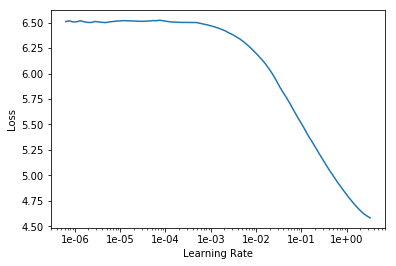

In [59]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.481068,1.909898,0.450105,00:10


In [22]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.231937,1.218382,0.631394,00:13
1,1.238995,1.223885,0.629097,00:13
2,1.219310,1.203504,0.635045,00:13
3,1.210485,1.208328,0.633810,00:13
4,1.178260,1.183156,0.641662,00:13
5,1.154104,1.175704,0.644551,00:13
6,1.133904,1.170966,0.645798,00:13
7,1.109461,1.167290,0.646882,00:13
8,1.102520,1.166125,0.647610,00:13
9,1.096980,1.166519,0.647564,00:13


In [33]:
TEXT = "meat"
N_WORDS = 40
N_SENTENCES = 10

In [34]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

meat s   e x p r e s s xxbos   p e t e r ' s   p i z z a xxbos   t h e   b a k e r y xxbos   w e
meat   w a n g xxbos   h a p p y   f o u r xxbos   y   e x p r e s s   t a k e a w a y xxbos   l
meat h e r s   r e s t a u r a n t xxbos   t h e   s a n d w i c h   c o   l t d xxbos   n o
meat s   p l a i c e xxbos   s p i c y   o f   t h e   c o t t a g e xxbos   w i n g s   c h
meat   s a n d w i c h   b a r xxbos   d e l i c i o u s   o f   i n d i a xxbos   b a l t i
meat   w a l l   c h i n e s e   t a k e a w a y xxbos   c a s p i a n   f i s h   b a r
meat   c h o i c e xxbos   f i s h   d e l i g h t s xxbos   b i r d   ' n '   s p i c e xxbos  
meat   c a n t o n e s e   t a k e a w a y xxbos   h i l l t o p   c h i p p y xxbos   s h a
meat   g o l d e n   p a l a c e   g r i l l xxbos   m i n i   f i s h   b a r xxbos   n e w
meat   t o w n   t a k e   a w a y xxbos   t h e   o l d   r o a d   f i s h   b a r xxbos  


In [35]:
learn.save('fine_tuned')

In [36]:
learn.save_encoder('fine_tuned_enc')

In [8]:
df = pd.read_csv('/rds/user/trpb2/hpc-work/data/takeaway/OS Data June 2019.txt', sep="|", encoding='latin-1')

/home/trpb2/.conda/envs/fastai_v1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7,14,15,16,22,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df.columns

Index(['UNIQUE_REFERENCE_NUMBER', 'NAME', 'POINTX_CLASSIFICATION_CODE',
       'FEATURE_EASTING', 'FEATURE_NORTHING', 'POSITIONAL_ACCURACY_CODE',
       'UPRN', 'TOPOGRAPHIC_TOID', 'TOPOGRAPHIC_TOID_VERSION', 'ITN_EASTING',
       'ITN_NORTHING', 'ITN_TOID', 'ITN_TOID_VERSION', 'DISTANCE',
       'ADDRESS_DETAIL', 'STREET_NAME', 'LOCALITY', 'GEOGRAPHIC_COUNTY',
       'POSTCODE', 'VERIFIED_ADDRESS', 'ADMINISTRATIVE_BOUNDARY',
       'TELEPHONE_NUMBER', 'URL', 'BRAND', 'QUALIFIER_TYPE', 'QUALIFIER_DATA',
       'PROVENANCE', 'DATE_OF_SUPPLY'],
      dtype='object')

In [11]:
restaurant_or_takeaway = ['1020018', '1020019', '1020020', '1020043', '1020034']
df_rest_take = df.loc[df['POINTX_CLASSIFICATION_CODE'].isin(restaurant_or_takeaway)].copy()

In [13]:
df_rest_take.head

<bound method NDFrame.head of          UNIQUE_REFERENCE_NUMBER                                     NAME  \
1180212                104416963              Frankley North Service Area   
1180989                 18857212            Welcome Break (Welcome Break)   
1180990                 18857216   Welcome Break (Michaelwood Southbound)   
1180991                 18857293  Roadchef (Strensham North Service Area)   
1180992                104416960               Trowell South Service Area   
1183805                 18857282           Roadchef (Durham Service Area)   
1183806                 19521783                Reading East Service Area   
1183807                 18857173                 Ferrybridge Service Area   
1183808                 18857178                     Kinross Service Area   
1183809                 18857192                     Swansea Service Area   
1183810                 80391591                  Dover Port Service Area   
1184527                 18857278  Roadchef (An

In [16]:
df_rest_take_trim = df_rest_take[['NAME','POINTX_CLASSIFICATION_CODE']].copy()
df_rest_take_trim.to_json(path_or_buf='/rds/user/trpb2/hpc-work/data/takeaway/OS_Data_June_2019_rest_take_names.txt')

In [5]:
df_rest_take_trim = pd.read_json(path_or_buf='/rds/user/trpb2/hpc-work/data/takeaway/OS_Data_June_2019_rest_take_names.txt')

In [6]:
df_rest_take_trim['NAME'] = df_rest_take_trim.NAME.str.lower()

In [7]:
msk = np.random.rand(len(df_rest_take_trim)) < 0.8
train_df = df_rest_take_trim[msk]
valid_df = df_rest_take_trim[~msk]

In [8]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [9]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'" +"0123456789")

In [10]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [11]:
data = TextLMDataBunch.from_df(path='.', train_df=train_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab, text_cols=0, mark_fields=False, bs=128)

In [28]:
data.show_batch()

idx,text
0,b r e a k xxunk m i c h a e l w o o d s o u t h b o u n d xxunk xxbos r o a d c h e f xxunk s t r e n s h a m n o r t h s e r v i c
1,o p xxbos s u b w a y xxbos a l t o n g o u r m e t o r i e n t a l xxbos g a s t r o n o m i c t a k e a w a y xxbos r a s h e
2,r n s p i c e r e s t a u r a n t xxbos r a g a m s o u t h i n d i a n r e s t a u r a n t xxbos c h r i s ' s f i
3,n d y i n n xxbos t h e h o p e xxbos p a c k o f c a r d s h o t e l xxbos t h e f a m o u s c o c k t a v
4,t d xxbos t h e r h i n o c e r o s xxbos f r a t e l l i xxbos t h e o w i n g t o n f a r m xxbos t h e c o a c h xxunk


In [12]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [13]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (109272 items)
x: LMTextList
xxbos   w e l c o m e   b r e a k   xxunk w e l c o m e   b r e a k xxunk,xxbos   w e l c o m e   b r e a k   xxunk m i c h a e l w o o d   s o u t h b o u n d xxunk,xxbos   r o a d c h e f   xxunk s t r e n s h a m   n o r t h   s e r v i c e   a r e a xxunk,xxbos   t r o w e l l   s o u t h   s e r v i c e   a r e a,xxbos   r o a d c h e f   xxunk d u r h a m   s e r v i c e   a r e a xxunk
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (27534 items)
x: LMTextList
xxbos   f r a n k l e y   n o r t h   s e r v i c e   a r e a,xxbos   r o a d c h e f   xxunk t i b s h e l f   s o u t h   s e r v i c e   a r e a xxunk,xxbos   w e l c o m e   b r e a k   xxunk c o b h a m xxunk   e x t r a   s e r v i c e s   xxunk,xxbos   w i n c h e s t e r   n o r t h   s e r v i c e   a r e a,xxbos   s p i c e   o f   i n d i a
y: LMLabelList
,,,,
Path: .;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encod

In [14]:
learn.freeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


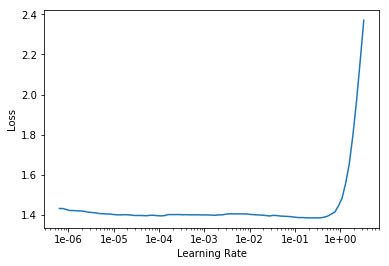

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.312149,1.225271,0.634112,00:32


In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.249619,1.156936,0.653952,00:41
1,1.182030,1.102624,0.670400,00:42
2,1.127125,1.077447,0.677490,00:42
3,1.100131,1.052491,0.683916,00:42
4,1.065412,1.037364,0.688658,00:42
5,1.032510,1.026469,0.691665,00:42
6,1.020167,1.019403,0.694094,00:42
7,1.000225,1.015075,0.695017,00:42
8,0.991106,1.014048,0.695538,00:42
9,0.982843,1.013690,0.695562,00:42


In [26]:
TEXT = "curry"
N_WORDS = 40
N_SENTENCES = 50

In [27]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

curry   p l a i c e xxbos   t h e   t h r e e   p i g e o n s xxbos   t h e   h o r s e   s h
curry   k i n g xxbos   t h e   r a v e n xxbos   t h e   p l o u g h xxbos   p r i n c e   a l b
curry   n i c e xxbos   p a n d a   g a r d e n xxbos   b a b a   k e b a b   h o u s e xxbos   i
curry   k i n g xxbos   o n e   d e l h i xxbos   p a p a ' s xxbos   t h e   b r i t i s h   o a
curry   b a n k xxbos   t h e   c r o w n   i n n xxbos   a l a d d i n s xxbos   d o m i n o ' s
curry   p a l a c e xxbos   t h e   f o x   i n n xxbos   c h a t i m e xxbos   t h e   a n c h o
curry   i n n xxbos   f o x   i n n xxbos   c h i n a   h o u s e xxbos   p i z z a   h u t xxbos   t
curry   b a r xxbos   l a   m e z z a   o r i e n t a l xxbos   m a s a l a   g a r d e n xxbos  
curry   l e a f   r e s t a u r a n t xxbos   t h e   p a r k   t a v e r n   l t d xxbos   d
curry   c o r n e r xxbos   w a s h i n g t o n   a r m s xxbos   t h e   c a r p e n t e r s
curry   h u t xxbos   t h e 

In [35]:
learn.save('fine_tuned')

In [36]:
learn.save_encoder('fine_tuned_enc')